In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle                             
!cp kaggle.json ~/.kaggle/   
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 97% 218M/225M [00:02<00:00, 126MB/s]
100% 225M/225M [00:02<00:00, 114MB/s]


In [3]:
!mkdir /content/data

In [4]:
cd /content/data

/content/data


In [5]:
!unzip -qq /content/flowers-recognition.zip

In [6]:
cd ..

/content


In [7]:
import os
from glob import glob

In [8]:
flower_dir = '/content/data/flowers'

print(f'Type of flowers : {os.listdir(flower_dir)}')

Type of flowers : ['dandelion', 'sunflower', 'daisy', 'rose', 'tulip']


In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import (
    Dataset,
    DataLoader,
)
import warnings
warnings.filterwarnings('ignore')


In [10]:
torch.manual_seed(42)
np.random.seed(42)

In [11]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees = (90,90)),
        transforms.RandomRotation(degrees = (180,180)),
        transforms.RandomRotation(degrees = (270,270)),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor(),
    ]
)

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Device Alotted : {device}')

In [13]:
def create_annotations_dataframe(root_dir):
    image_path = []
    image_label = []
    label_type = []
    
    for label_type_index, folder_name in enumerate(os.listdir(root_dir)):
        for img_path in os.listdir( os.path.join( root_dir , folder_name ) ):
            image_path.append(img_path)
            image_label.append(folder_name)
            label_type.append(label_type_index)
            
    annotations_df = pd.DataFrame({
        'path': image_path,
        'label': image_label,
        'type': label_type
    })
    
    return annotations_df.sample( frac = 1.0 )

In [14]:
data_df = create_annotations_dataframe(flower_dir)
data_df.head()

,path,label,type
3800,21084189635_425ca69aa0_n.jpg,tulip,4
2014,3711723108_65247a3170.jpg,daisy,2
1923,14421389519_d5fd353eb4.jpg,daisy,2
2533,5773652803_574b51414f_n.jpg,daisy,2
3747,5430796647_f21b7b0fea.jpg,tulip,4


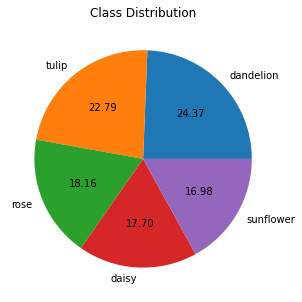

In [15]:
flower_types = data_df['label'].value_counts()
plt.figure( figsize = (5,5))
plt.pie(flower_types.values, labels = flower_types.index, autopct = '%.2f')
plt.title('Class Distribution')
plt.show()

In [16]:
class FlowerDataset(Dataset):
    
    def __init__(self, root, csv_file, height, width, transform = None):
        self.root = root
        self.csv_file = csv_file
        self.height = height
        self.width = width
        self.transform = transform
        self.subfolders = os.listdir(root)
    
    def __len__(self):
        img_count = 0
        for foldername in self.subfolders:
            img_count += len(os.listdir( os.path.join(self.root, foldername) ))
            
        return img_count
    
    def __getitem__(self, index):
        image_data = self.csv_file.iloc[index, :3].to_numpy()
        image_name, image_label, encoded_image_label = image_data
        image_path = os.path.join( os.path.join(self.root, image_label), image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.height, self.width))
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
            
        return (image, encoded_image_label)
    
    def get_image(self, index):
        image_data = self.csv_file.iloc[index, :2].to_numpy()
        image_name, image_label = image_data
        image_path = os.path.join( os.path.join(self.root, image_label), image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.height, self.width))
        
        return image
        

In [17]:
dataset = FlowerDataset(
    root = flower_dir,
    csv_file = data_df,
    height = 256,
    width = 256,
    transform = transform
)

In [18]:
print(f'Lnegth of the dataset : {dataset.__len__()}')

Lnegth of the dataset : 4317


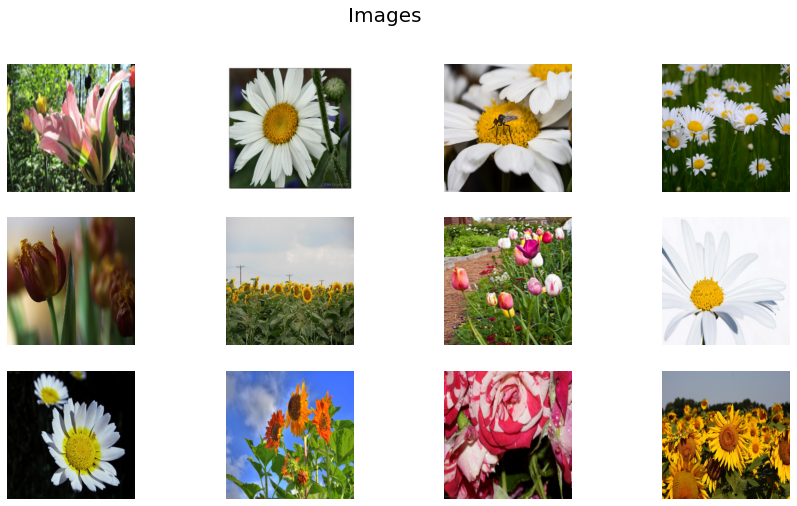

In [19]:
fig, ax = plt.subplots(3, 4, figsize = (15, 8))

plt.suptitle('Images', size = 20)

for i in range(12):
    plt.subplot(3, 4, i+1)
    image = dataset.get_image(i)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()

In [20]:
# Hyperparameters
input_channel = 3
num_classes = 2
learning_rate = 1e-4
batch_size = 10
num_epochs = 10
train_subset_length = int(dataset.__len__() * 0.8)
validation_subset_length = dataset.__len__() - train_subset_length

In [21]:
train_set, test_set = torch.utils.data.random_split(dataset, [train_subset_length, validation_subset_length])

In [22]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size)

In [27]:
class CNNet(nn.Module):

  def __init__(self, input_shape, num_classes):
    super(CNNet, self).__init__()
    self.input_shape = input_shape
    self.num_classes = num_classes
    #self.layers = layers
    self.conv1 = nn.Conv2d(in_channels = self.input_shape[0], out_channels = 16,kernel_size = 3,padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32,kernel_size = 3,padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 32,kernel_size = 3,padding = 1)
    self.pool = nn.MaxPool2d((2, 2))
    self.fc1 = nn.Linear(16*16*32, 1048)
    self.fc2 = nn.Linear(1048, 512)
    self.fc3 = nn.Linear(512, self.num_classes)

  def forward(self, x):
    x = nn.ReLU()(self.pool(self.conv1(x)))
    x = nn.ReLU()(self.pool(self.conv2(x)))
    x = nn.ReLU()(self.pool(self.conv3(x)))
    x = nn.ReLU()(self.pool(self.conv3(x)))
    x = nn.Flatten()(x)
    #print(x.shape)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = nn.Softmax()(x)
    return x

In [28]:
model = CNNet(input_shape = (3, 256, 256), num_classes = 5)
x = torch.tensor(np.random.randn(2,3,256,256), dtype=torch.float)

In [30]:
model(x)

tensor([[0.1966, 0.2018, 0.2095, 0.1989, 0.1932],
        [0.1957, 0.2025, 0.2099, 0.1981, 0.1938]], grad_fn=<SoftmaxBackward>)

In [31]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
loss_monitor_step = 30

In [32]:
for epoch in range(EPOCHS):
  print(f'Epoch : {epoch + 1}')
  print('Train Loss : [', end = " ")
  epoch_loss = 0.0
  for steps, (patch, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    patch_output = model(patch)
    loss = criterion(patch_output, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss
    if steps % loss_monitor_step == loss_monitor_step - 1:
      print('%.3f'%( epoch_loss / loss_monitor_step ), end = ' ')
      epoch_loss = 0.0
  print(']')
  print('......................................\n\n')

Epoch : 1
Train Loss : [ 1.613 1.602 1.591 1.551 1.552 1.573 1.531 1.514 1.484 1.497 1.468 ]
......................................


Epoch : 2
Train Loss : [ 1.455 1.477 1.471 1.359 1.428 1.421 1.399 1.404 1.391 1.382 1.366 ]
......................................


Epoch : 3
Train Loss : [ 1.354 1.439 1.389 1.348 1.368 1.364 1.327 1.379 1.352 1.345 1.339 ]
......................................


Epoch : 4
Train Loss : [ 1.336 1.390 1.346 1.280 1.327 1.332 1.309 1.365 1.308 1.330 1.314 ]
......................................


Epoch : 5
Train Loss : [ 1.351 1.373 1.323 1.253 1.333 1.338 1.299 1.369 1.342 1.325 1.283 ]
......................................


Epoch : 6
Train Loss : [ 1.351 1.332 1.299 1.238 1.303 1.306 1.287 1.367 1.303 1.330 1.282 ]
......................................


Epoch : 7
Train Loss : [ 1.347 1.320 1.315 1.239 1.292 1.303 1.273 1.332 1.268 1.309 1.270 ]
......................................


Epoch : 8
Train Loss : [ 1.299 1.315 1.299 1.224 1.281 1.313 1

In [33]:
from sklearn.metrics import f1_score

In [34]:
patch.shape[0]

3

In [35]:
def argmax(array):
  final_array = np.zeros(array.shape[0])
  array = array.detach().numpy()
  #print(array.shape)
  for i in range(len(array)):
    final_array[i] = int(np.argmax(array[i]))
  return final_array


In [36]:
def accuracy(dataloader):
  final_score = 0.0
  for index, (patch, labels) in enumerate(dataloader):
    patch_output = model(patch)
    output_labels = argmax(patch_output)
    batch_acc = f1_score(output_labels, labels, average = 'weighted')

    final_score += batch_acc
  return final_score / index

In [38]:
print(f"Accuracy of the train data : {'%.2f'%(accuracy(train_loader))}")

Accuracy of the train data : 0.62


In [39]:
print(f"Accuracy of the train data : {'%.2f'%(accuracy(test_loader))}")

Accuracy of the train data : 0.60
